In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
%matplotlib inline

In [2]:
af = np.load("data/autoens_learning_data.npz")
print(af.keys())
hf = np.load("data/hetmem_learning_data.npz")
print(hf.keys())

['p_recall', 'p_keys', 'p_weights', 'p_error', 'p_values']
['p_recall', 'p_keys', 'p_weights', 'p_error', 'p_values']


In [3]:
qs = af["p_keys"]
ans = af["p_values"]
f_rec = af["p_recall"]
g_rec = hf["p_recall"]

In [4]:
f_err = af["p_error"]
g_err = hf["p_error"]
fail_w = af["p_weights"]
good_w = hf["p_weights"]
print(f_err.shape)
print(g_err.shape)
print(fail_w.shape)
print(good_w.shape)

(10800, 10)
(10800, 10)
(1080, 10, 2400)
(1080, 10, 2400)


In [73]:
f_res = np.sum(np.abs(f_err), axis=1)
g_res = np.sum(np.abs(g_err), axis=1)

(30, 300)
(8400,)


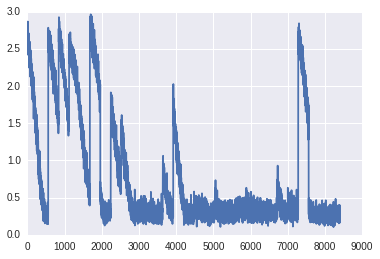

In [117]:
# Delete 5ms off of the onset of the question, since this is how long it takes
# for the answer to propigate to the network
per = int(0.3 / 0.001)
tmp_res = g_res[:9000].reshape((-1, per))
print(tmp_res.shape)
g_filt = np.delete(tmp_res, slice(0, 20), axis=1).flatten()
print(g_filt.shape)
plt.plot(g_filt)

In [74]:
def filt_outlier(dat, per=300, win=9000):
    tmp_res = dat[:win].reshape((-1, per))
    return np.delete(tmp_res, slice(0, 20), axis=1).flatten()

g_filt = filt_outlier(g_res)
f_filt = filt_outlier(f_res)

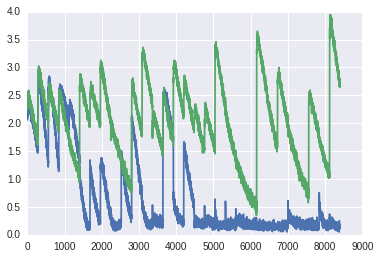

In [75]:
plt.plot(g_filt)
plt.plot(f_filt)

In [81]:
f_filtfilt = nengo.Lowpass(0.005).filtfilt(f_filt, dt=0.001)
g_filtfilt = nengo.Lowpass(0.005).filtfilt(g_filt, dt=0.001)

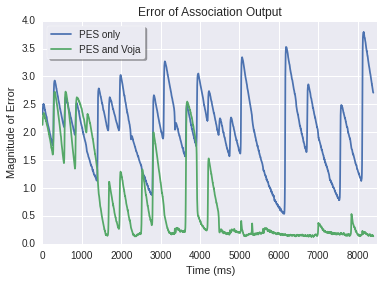

In [93]:
plt.plot(f_filtfilt)
plt.plot(g_filtfilt)
plt.xlim(0, 8500)
plt.title("Error of Association Output")
plt.ylabel("Magnitude of Error")
plt.xlabel("Time (ms)")
plt.legend(["PES only", "PES and Voja"], frameon=True, fancybox=True, shadow=True, loc=2)
plt.savefig("err_comp.pdf", format="pdf")

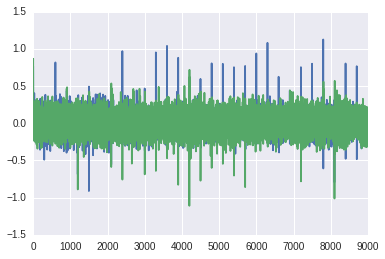

In [108]:
plt.plot(np.diff(g_res[:9000]))
plt.plot(np.diff(f_res[:9000]))

In [118]:
g_diff = np.diff(g_res[:9000])
print(g_diff.shape)
print(g_diff[g_diff > 0.6].shape)
print(np.arange(g_diff.size)[g_diff > 0.6])

f_diff = np.diff(f_res[:9000])
print(f_diff.shape)
print(f_diff[f_diff > 0.6].shape)
print(np.arange(f_diff.size)[f_diff > 0.6])

(8999,)
(18,)
[   1  599 2399 3299 3599 3900 4799 5099 5399 5699 6000 6300 6599 7199 7499
 7799 8399 8699]
(8999,)
(3,)
[   1 4203 4206]


Make weight plot

In [142]:
# plot the weights that fluctuated the most
# highest frequency?
# largest total diff?
print(good_w.shape)
print(fail_w.shape)

(1080, 10, 2400)
(1080, 10, 2400)


(1080, 32)


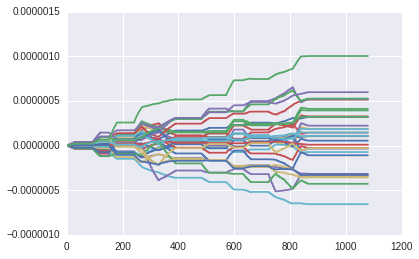

In [22]:
nrn = np.argmax(np.mean(np.var(weights, axis=0), axis=1))
pt_nrn = weights[..., nrn]
plt.plot(pt_nrn)
print(pt_nrn.shape)

In [24]:
nrn

15

(900, 10)


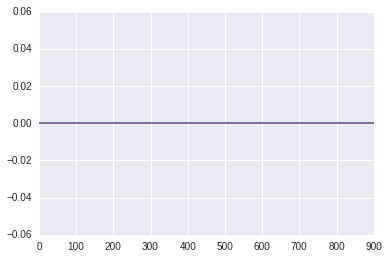

In [148]:
plt.plot(good_w[:900, :, 4])
print(good_w[:900, :, 3].shape)
#plt.plot(fail_w[:900, :, 3])
#print(good_w[:900, :, 3].shape)

In [19]:
def get_freqs(wt, win=900):
    tot_dims = wt.shape[1]
    tot_nrn = wt.shape[2]
    freqs = np.zeros((tot_dims, tot_nrn))
    
    for d in range(tot_dims):
        for n in range(tot_nrn):
            tmp_f = np.abs(np.fft.fft(wt[:win, d, n]))
            # remove the DC term, which just represent a shift
            tmp_f[0] = 0
            freqs[d, n] = np.sum(tmp_f)
    return freqs

g_freq = get_freqs(good_w)
f_freq = get_freqs(fail_w)
print(g_freq.shape)

(10, 2400)


In [20]:
g_max = np.unravel_index(np.argmax(g_freq), g_freq.shape)
f_max = np.unravel_index(np.argmax(f_freq), f_freq.shape)

In [21]:
print(g_max)
print(good_w[:900, g_max[0], g_max[1]].shape)
#print(good_w[:900, g_max].shape)

(4, 223)
(900,)


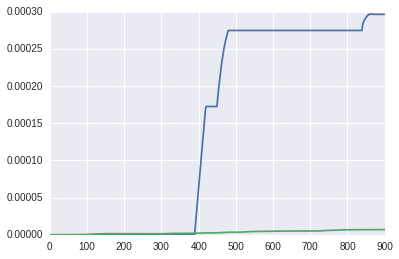

In [14]:
plt.plot(good_w[:900, g_max[0], g_max[1]])
plt.plot(fail_w[:900, f_max[0], f_max[1]])

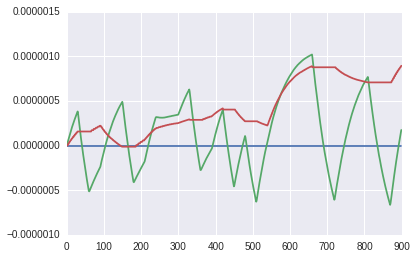

In [25]:
plt.plot(fail_w[:900, [1, 2, 4], [1, 2, 4]])
plt.savefig("wobbly")

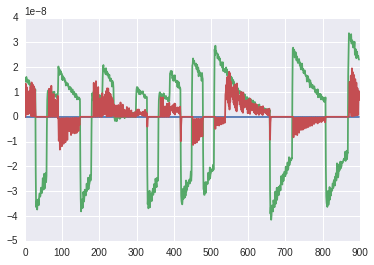

In [28]:
plt.plot(np.diff(fail_w[:900, [1, 2, 4], [1, 2, 4]], axis=0))

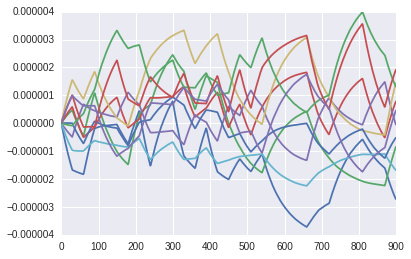

In [17]:
plt.plot(fail_w[:900, :, g_max[1]])

In [32]:
def get_diff(wt, win=900):
    tot_dims = wt.shape[1]
    tot_nrn = wt.shape[2]
    diffs = np.zeros((tot_dims, tot_nrn))
    
    for d in range(tot_dims):
        for n in range(tot_nrn):
            # remove the DC term, which just represent a shift
            diffs[d, n] = np.sum(np.abs(np.diff(wt[:win, d, n], axis=0)))
    return diffs

g_diff = get_diff(good_w)
f_diff = get_diff(fail_w)

In [56]:
gd_max = np.unravel_index(np.argmax(g_diff), g_diff.shape)
print(gd_max)
fd_max = np.unravel_index(np.argmax(f_diff), f_diff.shape)
print(fd_max)

(4, 2228)
(8, 226)


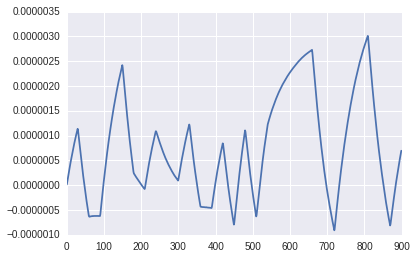

In [37]:
plt.plot(good_w[:900, gd_max[0], gd_max[1]])
plt.plot(fail_w[:900, fd_max[0], fd_max[1]])

In [61]:
g_sorted = np.argsort(g_diff, axis=None)
g_cord = np.unravel_index(g_sorted, g_diff.shape)
f_sorted = np.argsort(f_diff, axis=None)
f_cord = np.unravel_index(f_sorted, f_diff.shape)

In [70]:
stp = 100

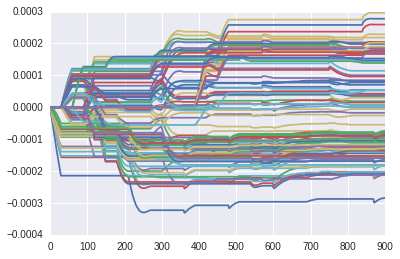

In [86]:
for x, y in zip(g_cord[0][::-1][:stp], g_cord[1][::-1][:stp]):
        plt.plot(good_w[:900, x, y])
plt.savefig("good_weights")

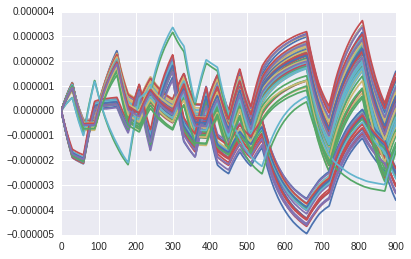

In [87]:
for x, y in zip(f_cord[0][::-1][:stp], f_cord[1][::-1][:stp]):
        plt.plot(fail_w[:900, x, y])
plt.savefig("fail_weights")